# Stock Price Prediction — Modeling
Goal: build a Python ML model to **predict next-day stock price** using `Data` and (most importantly) the **previous-day change in Data**, ignoring other real-world factors as per the assignment.

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn: model selection, models
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Sklearn: evaluation metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Utilities
import joblib
import warnings
warnings.filterwarnings("ignore")

# XGBoost
from xgboost import XGBRegressor
xgb_available = True

# Plot settings (pick ONE system)
sns.set_theme(style="darkgrid", palette="husl")
%matplotlib inline


def regression_metrics(y_true, y_pred):
    """
    Regression metrics safe for financial time series
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

## 1. Load Prepared Data
Load `merged_data.csv` if available (recommended).  
If not found, re-create the merged dataset from `Data.csv` and `StockPrice.csv`.

In [2]:
import os

# Paths (notebook is in: project/notebooks/)
MERGED_PATH = "../data/merged_data.csv"
DATA_PATH = "../data/Data.csv"
STOCK_PATH = "../data/StockPrice.csv"

if os.path.exists(MERGED_PATH):
    df = pd.read_csv(MERGED_PATH, parse_dates=["Date"])
    print(f"✅ Loaded merged file: {MERGED_PATH}")
else:
    raise FileNotFoundError(
        "merged_data.csv not found. "
        "Please run the feature engineering notebook first."
    )

# Enforce chronological order
df = df.sort_values("Date").reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} → {df['Date'].max()}")

df.head()

✅ Loaded merged file: ../data/merged_data.csv
Dataset shape: (3762, 27)
Date range: 2010-03-03 00:00:00 → 2025-03-26 00:00:00


,Date,Data,Price,days_gap,Data_Change,Data_Pct_Change,Price_Change,Price_Pct_Change,Data_Lag_1,Data_Lag_2,...,Data_Change_Lag_3,Data_Change_Lag_4,Data_Change_Lag_5,Data_Change_Lag_6,Data_Change_Lag_7,Data_MA_2,Data_MA_5,Data_MA_7,Data_MA_10,Data_MA_40
0,2010-03-03,0.655,1167.75,1.0,0.000,0.000000,1.00,0.085708,0.655,0.655,...,-0.002,-0.001,-0.002,0.000,0.000,0.6550,0.6558,0.657000,0.6581,0.668900
1,2010-03-04,0.654,1171.50,1.0,-0.001,-0.152672,3.75,0.321130,0.655,0.655,...,-0.001,-0.002,-0.001,-0.002,0.000,0.6545,0.6550,0.656000,0.6575,0.667775
2,2010-03-05,0.653,1185.75,1.0,-0.001,-0.152905,14.25,1.216389,0.654,0.655,...,0.000,-0.001,-0.002,-0.001,-0.002,0.6535,0.6544,0.655143,0.6567,0.666750
3,2010-03-08,0.652,1186.25,3.0,-0.001,-0.153139,0.50,0.042167,0.653,0.654,...,0.000,0.000,-0.001,-0.002,-0.001,0.6525,0.6538,0.654286,0.6558,0.665750
4,2010-03-09,0.652,1189.75,1.0,0.000,0.000000,3.50,0.295047,0.652,0.653,...,-0.001,0.000,0.000,-0.001,-0.002,0.6520,0.6532,0.653714,0.6549,0.664775


In [3]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

print("\nDate range:")
print("  From:", df["Date"].min())
print("  To  :", df["Date"].max())

# Verify required columns
required_cols = {"Date", "Data", "Price"}
missing = required_cols - set(df.columns)

if missing:
    raise ValueError(f"Missing required columns: {missing}")
else:
    print("\n✅ Required columns present:", required_cols)

Shape: (3762, 27)
Columns: ['Date', 'Data', 'Price', 'days_gap', 'Data_Change', 'Data_Pct_Change', 'Price_Change', 'Price_Pct_Change', 'Data_Lag_1', 'Data_Lag_2', 'Data_Lag_3', 'Data_Lag_4', 'Data_Lag_5', 'Data_Lag_6', 'Data_Lag_7', 'Data_Change_Lag_1', 'Data_Change_Lag_2', 'Data_Change_Lag_3', 'Data_Change_Lag_4', 'Data_Change_Lag_5', 'Data_Change_Lag_6', 'Data_Change_Lag_7', 'Data_MA_2', 'Data_MA_5', 'Data_MA_7', 'Data_MA_10', 'Data_MA_40']

Date range:
  From: 2010-03-03 00:00:00
  To  : 2025-03-26 00:00:00

✅ Required columns present: {'Date', 'Data', 'Price'}


## 2. Modeling Dataset Creation (Features + Target)
We create change-based, lag-based, and rolling-window features from `Data`, and set the target as **next-day Price** to frame this as a forecasting problem.

In [4]:
# --- Feature contract enforcement ---
expected_cols = {
    # Core
    "Date", "Data", "Price",

    # Targets / changes
    "Price_Change", "Price_Pct_Change",
    "Data_Change", "Data_Pct_Change",

    # Trading gap
    "days_gap",

    # Approved lags
    "Data_Lag_1", "Data_Lag_2", "Data_Lag_3", "Data_Lag_5", "Data_Lag_4", "Data_Lag_6", "Data_Lag_7",
    "Data_Change_Lag_1", "Data_Change_Lag_2", "Data_Change_Lag_3", "Data_Change_Lag_4", "Data_Change_Lag_5", "Data_Change_Lag_6", "Data_Change_Lag_7",

    # Approved rolling features
    "Data_MA_2", "Data_MA_5", "Data_MA_7", "Data_MA_10", "Data_MA_40",
}

missing = expected_cols - set(df.columns)

if missing:
    raise ValueError(
        "❌ Feature mismatch detected.\n"
        f"Missing columns: {sorted(missing)}\n"
        "Run the feature engineering notebook again."
    )

print("✅ Feature contract verified")
print(f"Total columns: {df.shape[1]}")

✅ Feature contract verified
Total columns: 27


In [5]:
# --- Target: next-day price change ---
df["TargetPriceChange"] = df["Price"].shift(-1) - df["Price"]

# --- Feature groups (FINAL, CONTRACTED) ---
price_features = [
    "Price",
    "Price_Change",
    "Price_Pct_Change",
    "days_gap",
]

data_features = [
    "Data",
    "Data_Change",
    "Data_Pct_Change",
    "Data_MA_2",
    "Data_MA_5",
    "Data_MA_7",
    "Data_MA_10",
    "Data_MA_40",
]

lag_features = [
    "Data_Lag_1",
    "Data_Lag_2",
    "Data_Lag_3",
    "Data_Lag_4",
    "Data_Lag_5",
    "Data_Lag_6",
    "Data_Lag_7",
    "Data_Change_Lag_1",
    "Data_Change_Lag_2",
    "Data_Change_Lag_3",
    "Data_Change_Lag_4",
    "Data_Change_Lag_5",
    "Data_Change_Lag_6",
    "Data_Change_Lag_7",
]

X_cols = price_features + data_features + lag_features
y_col = "TargetPriceChange"

print(f"Feature count: {len(X_cols)}")
print("Features used:")
print(X_cols)

# --- Drop NaNs (from shift / rolling) ---
df_model = df.dropna(subset=X_cols + [y_col]).reset_index(drop=True)

print("\nRaw df shape:   ", df.shape)
print("Model df shape: ", df_model.shape)
print("Rows dropped:   ", len(df) - len(df_model))

Feature count: 26
Features used:
['Price', 'Price_Change', 'Price_Pct_Change', 'days_gap', 'Data', 'Data_Change', 'Data_Pct_Change', 'Data_MA_2', 'Data_MA_5', 'Data_MA_7', 'Data_MA_10', 'Data_MA_40', 'Data_Lag_1', 'Data_Lag_2', 'Data_Lag_3', 'Data_Lag_4', 'Data_Lag_5', 'Data_Lag_6', 'Data_Lag_7', 'Data_Change_Lag_1', 'Data_Change_Lag_2', 'Data_Change_Lag_3', 'Data_Change_Lag_4', 'Data_Change_Lag_5', 'Data_Change_Lag_6', 'Data_Change_Lag_7']

Raw df shape:    (3762, 28)
Model df shape:  (3761, 28)
Rows dropped:    1


In [6]:
# Final X and y
X = df_model[X_cols].copy()
X = X[X_cols]   # enforce column order

y = df_model[y_col].copy()

# Keep Date for plotting later
dates = df_model["Date"].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

display(
    df_model[["Date"] + X_cols[:6] + [y_col]].head(10)
)

X shape: (3761, 26)
y shape: (3761,)


,Date,Price,Price_Change,Price_Pct_Change,days_gap,Data,Data_Change,TargetPriceChange
0,2010-03-03,1167.75,1.00,0.085708,1.0,0.655,0.000,3.75
1,2010-03-04,1171.50,3.75,0.321130,1.0,0.654,-0.001,14.25
2,2010-03-05,1185.75,14.25,1.216389,1.0,0.653,-0.001,0.50
3,2010-03-08,1186.25,0.50,0.042167,3.0,0.652,-0.001,3.50
4,2010-03-09,1189.75,3.50,0.295047,1.0,0.652,0.000,5.25
5,2010-03-10,1195.00,5.25,0.441269,1.0,0.651,-0.001,4.75
6,2010-03-11,1199.75,4.75,0.397490,1.0,0.650,-0.001,0.75
7,2010-03-12,1200.50,0.75,0.062513,1.0,0.649,-0.001,-1.00
8,2010-03-15,1199.50,-1.00,-0.083299,3.0,0.646,-0.003,9.25
9,2010-03-16,1208.75,9.25,0.771155,1.0,0.646,0.000,6.25


## 3. Train–Test Split (Time-Based)
We split the data **chronologically** (no shuffling) to simulate real forecasting: train on past data and test on future data.

In [7]:
# Chronological split (e.g., 80% train, 20% test)
split_ratio = 0.90
n = len(df_model)
split_idx = int(n * split_ratio)

print("Total rows:", n)
print("Train rows:", split_idx)
print("Test rows: ", n - split_idx)

print("\nTrain date range:", df_model["Date"].iloc[0], "to", df_model["Date"].iloc[split_idx - 1])
print("Test date range: ", df_model["Date"].iloc[split_idx], "to", df_model["Date"].iloc[-1])

Total rows: 3761
Train rows: 3384
Test rows:  377

Train date range: 2010-03-03 00:00:00 to 2023-09-18 00:00:00
Test date range:  2023-09-19 00:00:00 to 2025-03-25 00:00:00


In [8]:
# Split features/target chronologically
X_train = X.iloc[:split_idx].copy()
X_test  = X.iloc[split_idx:].copy()

y_train = y.iloc[:split_idx].copy()
y_test  = y.iloc[split_idx:].copy()

# Keep dates for plotting predictions later
Date_train = dates.iloc[:split_idx].copy()
Date_test  = dates.iloc[split_idx:].copy()

print("X_train:", X_train.shape, " | y_train:", y_train.shape)
print("X_test: ", X_test.shape,  " | y_test: ", y_test.shape)

display(pd.DataFrame({
    "Date_test_head": Date_test.head(5).astype(str).values,
    "y_test_head": y_test.head(5).values
}))

X_train: (3384, 26)  | y_train: (3384,)
X_test:  (377, 26)  | y_test:  (377,)


,Date_test_head,y_test_head
0,2023-09-19,-43.00
1,2023-09-20,-75.00
2,2023-09-21,-11.00
3,2023-09-22,17.75
4,2023-09-25,-64.00


## 5. Primary Model — RandomForestRegressor
Random Forest is a strong default because it captures non-linear relationships and interactions between lag/change features without needing scaling.

In [9]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

print("RF trained")
print("OOB R²:", rf.oob_score_)

RF trained
OOB R²: -0.024626814074303338


In [10]:
# Predict CHANGE on test set
y_pred_change_rf = rf.predict(X_test)

# Metrics for CHANGE
metrics_rf_change = regression_metrics(y_test, y_pred_change_rf)
print("=== RandomForest: Predicting Price CHANGE ===")
print(metrics_rf_change)
print("\nNote: Negative R² is common for financial returns and not a failure.")

# --- Reconstruct next-day PRICE ---
today_price_test = X_test["Price"].values
y_pred_price_rf = today_price_test + y_pred_change_rf

# True next-day price
y_true_price = today_price_test + y_test.values

# Metrics for RECONSTRUCTED PRICE
metrics_rf_price = regression_metrics(y_true_price, y_pred_price_rf)
print("\n=== RandomForest: Reconstructed Next-Day PRICE ===")
print(metrics_rf_price)

=== RandomForest: Predicting Price CHANGE ===
{'MSE': 2307.175378259575, 'RMSE': 48.03306546806663, 'MAE': 37.154642553895606, 'R2': -0.14029880374833725}

Note: Negative R² is common for financial returns and not a failure.

=== RandomForest: Reconstructed Next-Day PRICE ===
{'MSE': 2307.1753782595747, 'RMSE': 48.033065468066624, 'MAE': 37.15464255389562, 'R2': 0.9903265612219868}


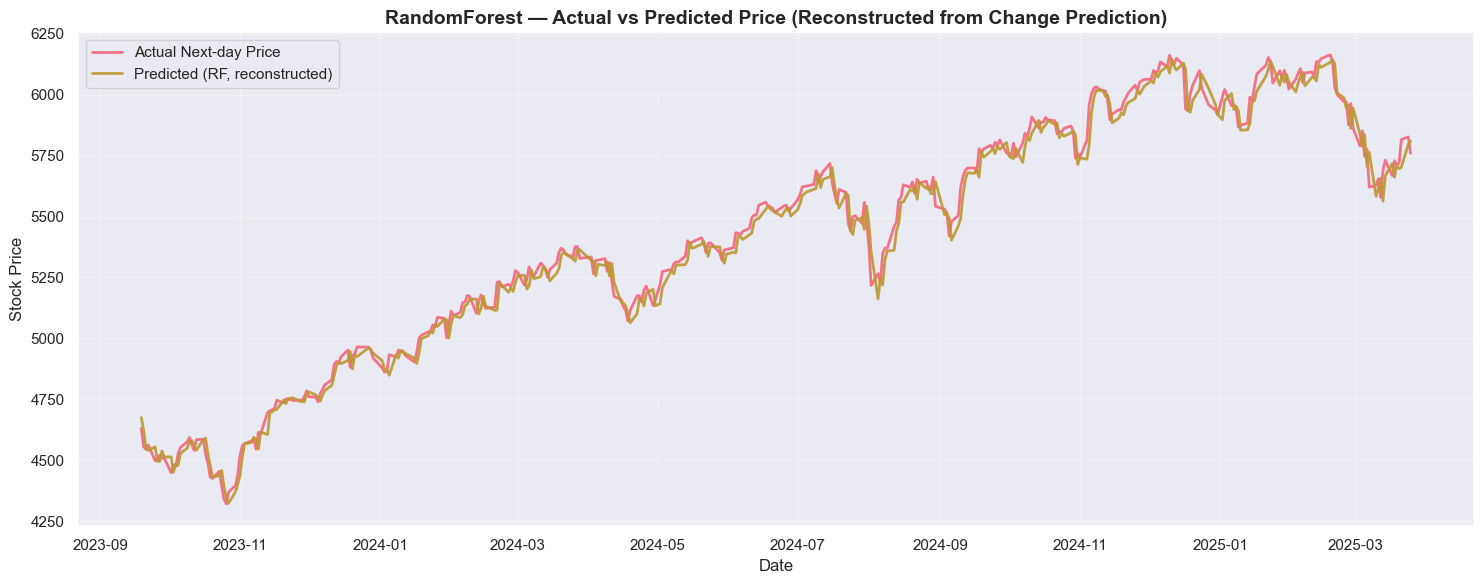

In [11]:
# %%
# Plot: Actual vs Predicted PRICE over time (reconstructed from change)
plt.figure(figsize=(15, 6))
plt.plot(Date_test, y_true_price, label="Actual Next-day Price", linewidth=2)
plt.plot(Date_test, y_pred_price_rf, label="Predicted (RF, reconstructed)", linewidth=2, alpha=0.9)
plt.title("RandomForest — Actual vs Predicted Price (Reconstructed from Change Prediction)", 
          fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

,feature,importance
1,Price_Change,0.121651
2,Price_Pct_Change,0.078776
25,Data_Change_Lag_7,0.067097
19,Data_Change_Lag_1,0.066128
22,Data_Change_Lag_4,0.061852
21,Data_Change_Lag_3,0.059628
24,Data_Change_Lag_6,0.057966
0,Price,0.057776
23,Data_Change_Lag_5,0.055809
6,Data_Pct_Change,0.055158


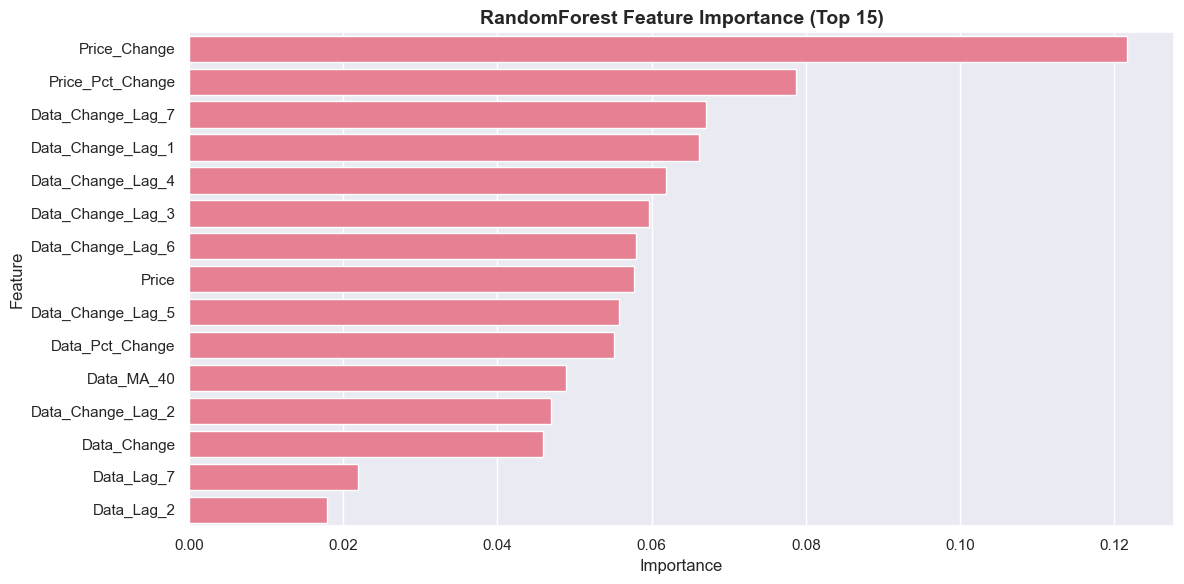

In [12]:
# Feature importance
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

display(importances.head(15))

# Plot top 15
plt.figure(figsize=(12, 6))
sns.barplot(data=importances.head(15), x="importance", y="feature", orient="h")
plt.title("RandomForest Feature Importance (Top 15)", fontsize=14, fontweight="bold")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 6. Model Improvement — XGBoostRegressor
XGBoost is often stronger than Random Forest on tabular time-series features (lags/rolling stats).  
If `xgboost` is not installed, install it with: `pip install xgboost`.

In [13]:
if xgb_available:
    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    xgb.fit(X_train, y_train)

    # --- Predict CHANGE ---
    y_pred_change_xgb = xgb.predict(X_test)
    metrics_xgb_change = regression_metrics(y_test, y_pred_change_xgb)

    print("=== XGBoost: Predicting Price CHANGE ===")
    print(metrics_xgb_change)

    # --- Reconstruct PRICE ---
    today_price_test = X_test["Price"].values
    y_pred_price_xgb = today_price_test + y_pred_change_xgb
    y_true_price = today_price_test + y_test.values

    metrics_xgb_price = regression_metrics(y_true_price, y_pred_price_xgb)

    print("\n=== XGBoost: Reconstructed Next-Day PRICE ===")
    print(metrics_xgb_price)

    # --- Compare FAIRLY ---
    print("\n=== Model Comparison (Reconstructed PRICE) ===")
    print("RandomForest:", metrics_rf_price)
    print("XGBoost:     ", metrics_xgb_price)

=== XGBoost: Predicting Price CHANGE ===
{'MSE': 2382.2463052883513, 'RMSE': 48.808260625516574, 'MAE': 38.11461978245635, 'R2': -0.17740187319586553}

=== XGBoost: Reconstructed Next-Day PRICE ===
{'MSE': 2382.2463052883513, 'RMSE': 48.808260625516574, 'MAE': 38.11461978245635, 'R2': 0.9900118066422248}

=== Model Comparison (Reconstructed PRICE) ===
RandomForest: {'MSE': 2307.1753782595747, 'RMSE': 48.033065468066624, 'MAE': 37.15464255389562, 'R2': 0.9903265612219868}
XGBoost:      {'MSE': 2382.2463052883513, 'RMSE': 48.808260625516574, 'MAE': 38.11461978245635, 'R2': 0.9900118066422248}


Importance type used: gain


,feature,importance
13,Data_Lag_2,2336.774414
11,Data_MA_40,2030.408203
15,Data_Lag_4,2024.886841
16,Data_Lag_5,1917.008301
19,Data_Change_Lag_1,1853.372070
12,Data_Lag_1,1780.338867
14,Data_Lag_3,1697.328369
23,Data_Change_Lag_5,1697.295654
9,Data_MA_7,1696.562256
7,Data_MA_2,1674.421631


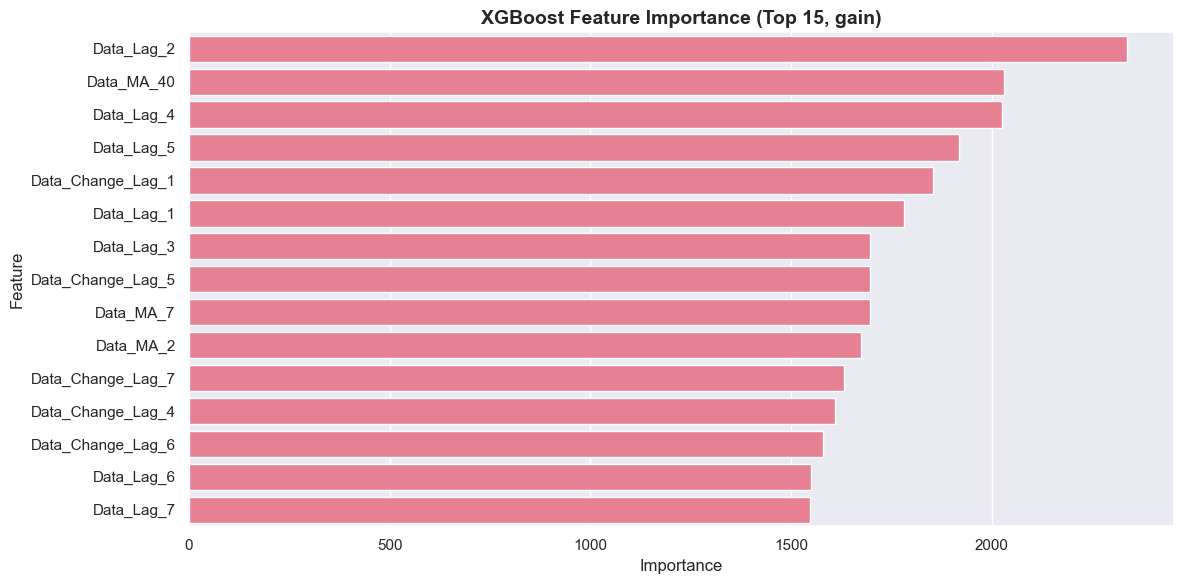

In [14]:
if xgb_available:
    booster = xgb.get_booster()

    # Try gain first; fallback to weight
    try:
        score = booster.get_score(importance_type="gain")
        imp_type_used = "gain"
    except Exception:
        score = booster.get_score(importance_type="weight")
        imp_type_used = "weight"

    feature_names = list(X_train.columns)

    def map_feature_name(k, feature_names):
        # Case 1: "f12" style
        if isinstance(k, str) and k.startswith("f") and k[1:].isdigit():
            idx = int(k[1:])
            return feature_names[idx] if idx < len(feature_names) else k
        # Case 2: already a feature name
        return k

    imp_df = pd.DataFrame({
        "feature": [map_feature_name(k, feature_names) for k in score.keys()],
        "importance": list(score.values())
    }).sort_values("importance", ascending=False)

    print(f"Importance type used: {imp_type_used}")
    display(imp_df.head(15))

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=imp_df.head(15),
        x="importance",
        y="feature",
        orient="h"
    )
    plt.title(f"XGBoost Feature Importance (Top 15, {imp_type_used})",
              fontsize=14, fontweight="bold")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

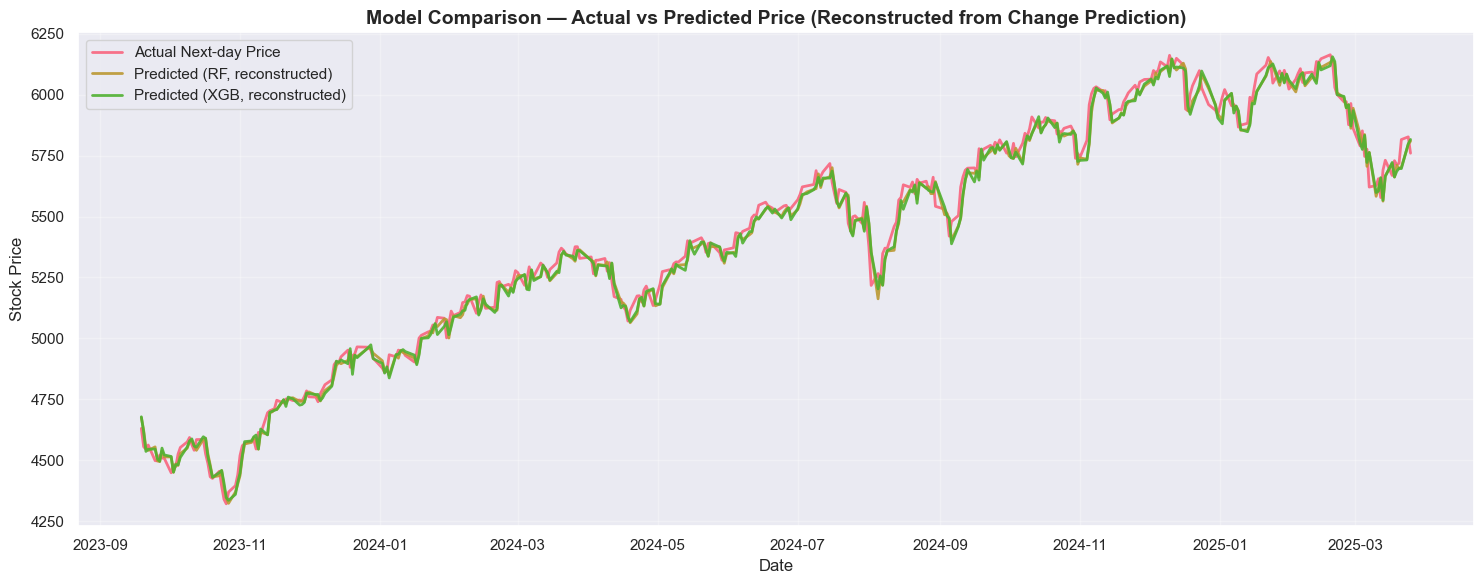

In [15]:
# %%
# Plot: Actual vs Predicted PRICE over time (reconstructed from change)
plt.figure(figsize=(15, 6))
plt.plot(Date_test, y_true_price, label="Actual Next-day Price", linewidth=2)
plt.plot(Date_test, y_pred_price_rf, label="Predicted (RF, reconstructed)", linewidth=2, alpha=0.9)
plt.plot(Date_test, y_pred_price_xgb, label="Predicted (XGB, reconstructed)", linewidth=2, alpha=0.9)
plt.title("Model Comparison — Actual vs Predicted Price (Reconstructed from Change Prediction)", 
          fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np

LOOKBACK = 40  # medium-term horizon

# Use SAME features as tree models
X_lstm_raw = df_model[X_cols].values
y_lstm_raw = df_model[y_col].values
dates_lstm = df_model["Date"].values

# Scale features (REQUIRED for LSTM)
scaler = StandardScaler()
X_lstm_scaled = scaler.fit_transform(X_lstm_raw)

def create_sequences(X, y, dates, lookback):
    X_seq, y_seq, d_seq = [], [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])
        d_seq.append(dates[i])
    return np.array(X_seq), np.array(y_seq), np.array(d_seq)

X_seq, y_seq, date_seq = create_sequences(
    X_lstm_scaled, y_lstm_raw, dates_lstm, LOOKBACK
)

print("Sequences:", X_seq.shape, y_seq.shape)


Sequences: (3721, 40, 26) (3721,)


In [17]:
split_idx_seq = int(len(X_seq) * split_ratio)

X_train_seq = X_seq[:split_idx_seq]
X_test_seq  = X_seq[split_idx_seq:]

y_train_seq = y_seq[:split_idx_seq]
y_test_seq  = y_seq[split_idx_seq:]

date_test_seq = date_seq[split_idx_seq:]

print("Train:", X_train_seq.shape, y_train_seq.shape)
print("Test: ", X_test_seq.shape, y_test_seq.shape)


Train: (3348, 40, 26) (3348,)
Test:  (373, 40, 26) (373,)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def build_medium_term_trading_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),

        LSTM(64, return_sequences=True),
        Dropout(0.2),

        LSTM(32),
        Dropout(0.2),

        Dense(16, activation="relu"),
        Dense(1)   # predicts NEXT-DAY PRICE CHANGE
    ])

    model.compile(
        optimizer="adam",
        loss="mse"
    )
    return model

lstm_model = build_medium_term_trading_lstm(X_train_seq.shape[1:])
lstm_model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 64)            23296     
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 36257 (141.63 KB)
Trainable params: 362

In [20]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100

105/105 [==============================] - 5s 23ms/step - loss: 929.8867 - val_loss: 2032.8022
Epoch 2/100
105/105 [==============================] - 2s 17ms/step - loss: 929.4098 - val_loss: 2032.4270
Epoch 3/100
105/105 [==============================] - 2s 17ms/step - loss: 929.0540 - val_loss: 2031.7037
Epoch 4/100
105/105 [==============================] - 2s 17ms/step - loss: 928.8727 - val_loss: 2030.3257
Epoch 5/100
105/105 [==============================] - 2s 17ms/step - loss: 928.7570 - val_loss: 2031.4990
Epoch 6/100
105/105 [==============================] - 2s 17ms/step - loss: 928.4545 - val_loss: 2031.4052
Epoch 7/100
105/105 [==============================] - 2s 17ms/step - loss: 928.6658 - val_loss: 2030.5598
Epoch 8/100
105/105 [==============================] - 2s 17ms/step - loss: 928.5768 - val_loss: 2032.6030
Epoch 9/100
105/105 [==============================] - 2s 17ms/step - loss: 928.6012 - val_loss: 2031.7269
Epoch 10/100
105/105 [==============

In [21]:
# Predict next-day CHANGE
y_pred_change_lstm = lstm_model.predict(X_test_seq).flatten()

metrics_lstm_change = regression_metrics(y_test_seq, y_pred_change_lstm)
print("=== LSTM: Predicting Price CHANGE ===")
print(metrics_lstm_change)

# --- SAFE price reconstruction ---
# Use df_model directly with aligned dates
price_series = df_model.set_index("Date")["Price"]

today_price_test = price_series.loc[date_test_seq].values

y_pred_price_lstm = today_price_test + y_pred_change_lstm
y_true_price_lstm = today_price_test + y_test_seq

metrics_lstm_price = regression_metrics(y_true_price_lstm, y_pred_price_lstm)
print("\n=== LSTM: Reconstructed Next-Day PRICE ===")
print(metrics_lstm_price)

12/12 [==============================] - 1s 5ms/step
=== LSTM: Predicting Price CHANGE ===
{'MSE': 2028.8617519595525, 'RMSE': 45.04288791762305, 'MAE': 33.53647893714162, 'R2': -0.0034506725844101194}

=== LSTM: Reconstructed Next-Day PRICE ===
{'MSE': 2028.8617519595525, 'RMSE': 45.04288791762305, 'MAE': 33.53647893714162, 'R2': 0.9913075383231612}


In [22]:
LONG_TH  =  0.002   # tune later
SHORT_TH = -0.002

signals_lstm = np.where(
    y_pred_change_lstm > LONG_TH,  1,
    np.where(y_pred_change_lstm < SHORT_TH, -1, 0)
)

print("Signal distribution:", np.unique(signals_lstm, return_counts=True))

Signal distribution: (array([1]), array([373], dtype=int64))


In [23]:
direction_true = np.sign(y_test_seq)
direction_pred = np.sign(y_pred_change_lstm)

directional_accuracy = np.mean(direction_true == direction_pred)
print("LSTM Directional Accuracy:", round(directional_accuracy, 4))


LSTM Directional Accuracy: 0.5737


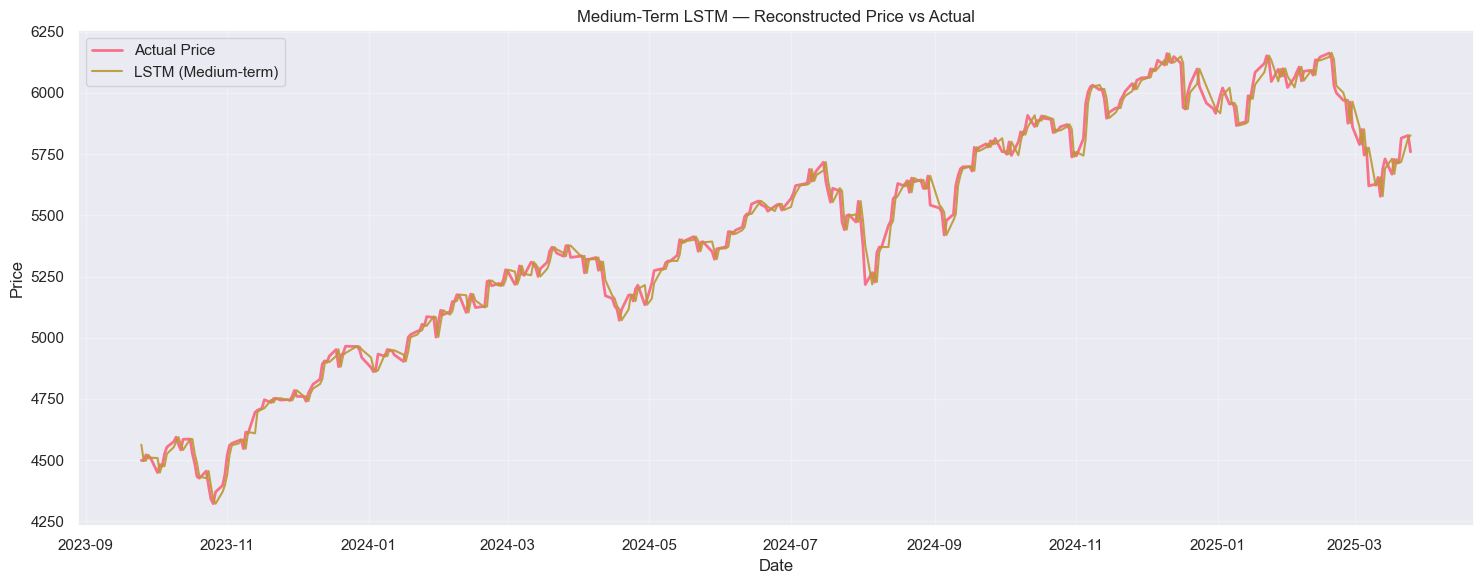

In [26]:
# --- Correct persistence baseline for LSTM ---

plt.figure(figsize=(15, 6))
plt.plot(date_test_seq, y_true_price_lstm, label="Actual Price", linewidth=2)
plt.plot(date_test_seq, y_pred_price_lstm, label="LSTM (Medium-term)", alpha=0.9)

plt.title("Medium-Term LSTM — Reconstructed Price vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Hyperparameter Tuning (TimeSeriesSplit CV)
We tune hyperparameters using **time-series cross-validation** (no shuffling) to avoid leakage and better simulate forecasting.

In [27]:
# Time-series CV (keeps order)
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search space (RF)
rf_param_dist = {
    "n_estimators": [200, 300],
    "max_depth": [None, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", 0.5],
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=50,                       # increase to 50 if you have time
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

print("✅ RF best CV score (neg RMSE):", rf_search.best_score_)
print("✅ RF best params:")
print(rf_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ RF best CV score (neg RMSE): -29.570574257955776
✅ RF best params:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


In [28]:
best_rf = rf_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
metrics_best_rf = regression_metrics(y_test, y_pred_best_rf)

print("=== Best RF (Tuned) — Holdout Test Metrics ===")
print(metrics_best_rf)

=== Best RF (Tuned) — Holdout Test Metrics ===
{'MSE': 2117.0697541821846, 'RMSE': 46.011626293603065, 'MAE': 35.094777834581734, 'R2': -0.04634096345411298}


In [29]:
tuning_results = {
    "rf_best_cv_neg_rmse": rf_search.best_score_,
    "rf_best_params": rf_search.best_params_,
    "rf_holdout_metrics": metrics_best_rf
}

if xgb_available:
    xgb_param_dist = {
        "n_estimators": [300, 500, 800],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 4, 5, 6, 8],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "reg_lambda": [0, 1, 5, 10],
    }

    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    xgb_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=xgb_param_dist,
        n_iter=25,
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    xgb_search.fit(X_train, y_train)

    print("\n✅ XGB best CV score (neg RMSE):", xgb_search.best_score_)
    print("✅ XGB best params:")
    print(xgb_search.best_params_)

    best_xgb = xgb_search.best_estimator_
    y_pred_best_xgb = best_xgb.predict(X_test)
    metrics_best_xgb = regression_metrics(y_test, y_pred_best_xgb)

    print("\n=== Best XGB (Tuned) — Holdout Test Metrics ===")
    print(metrics_best_xgb)

    tuning_results.update({
        "xgb_best_cv_neg_rmse": xgb_search.best_score_,
        "xgb_best_params": xgb_search.best_params_,
        "xgb_holdout_metrics": metrics_best_xgb
    })

# Record/print results (save to file later in the “Save artifacts” section)
tuning_results

Fitting 5 folds for each of 25 candidates, totalling 125 fits

✅ XGB best CV score (neg RMSE): -29.65090381693808
✅ XGB best params:
{'subsample': 1.0, 'reg_lambda': 5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

=== Best XGB (Tuned) — Holdout Test Metrics ===
{'MSE': 2044.0269751808785, 'RMSE': 45.21091654878143, 'MAE': 34.19824952009413, 'R2': -0.010240286278685451}


{'rf_best_cv_neg_rmse': -29.570574257955776,
 'rf_best_params': {'n_estimators': 300,
  'min_samples_split': 2,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'max_depth': 10},
 'rf_holdout_metrics': {'MSE': 2117.0697541821846,
  'RMSE': 46.011626293603065,
  'MAE': 35.094777834581734,
  'R2': -0.04634096345411298},
 'xgb_best_cv_neg_rmse': -29.65090381693808,
 'xgb_best_params': {'subsample': 1.0,
  'reg_lambda': 5,
  'n_estimators': 300,
  'max_depth': 5,
  'learning_rate': 0.01,
  'colsample_bytree': 0.8},
 'xgb_holdout_metrics': {'MSE': 2044.0269751808785,
  'RMSE': 45.21091654878143,
  'MAE': 34.19824952009413,
  'R2': -0.010240286278685451}}

## 8. Residual Analysis & Diagnostics
Analyzing residuals helps check if our model has systematic biases or non-constant variance (heteroscedasticity).

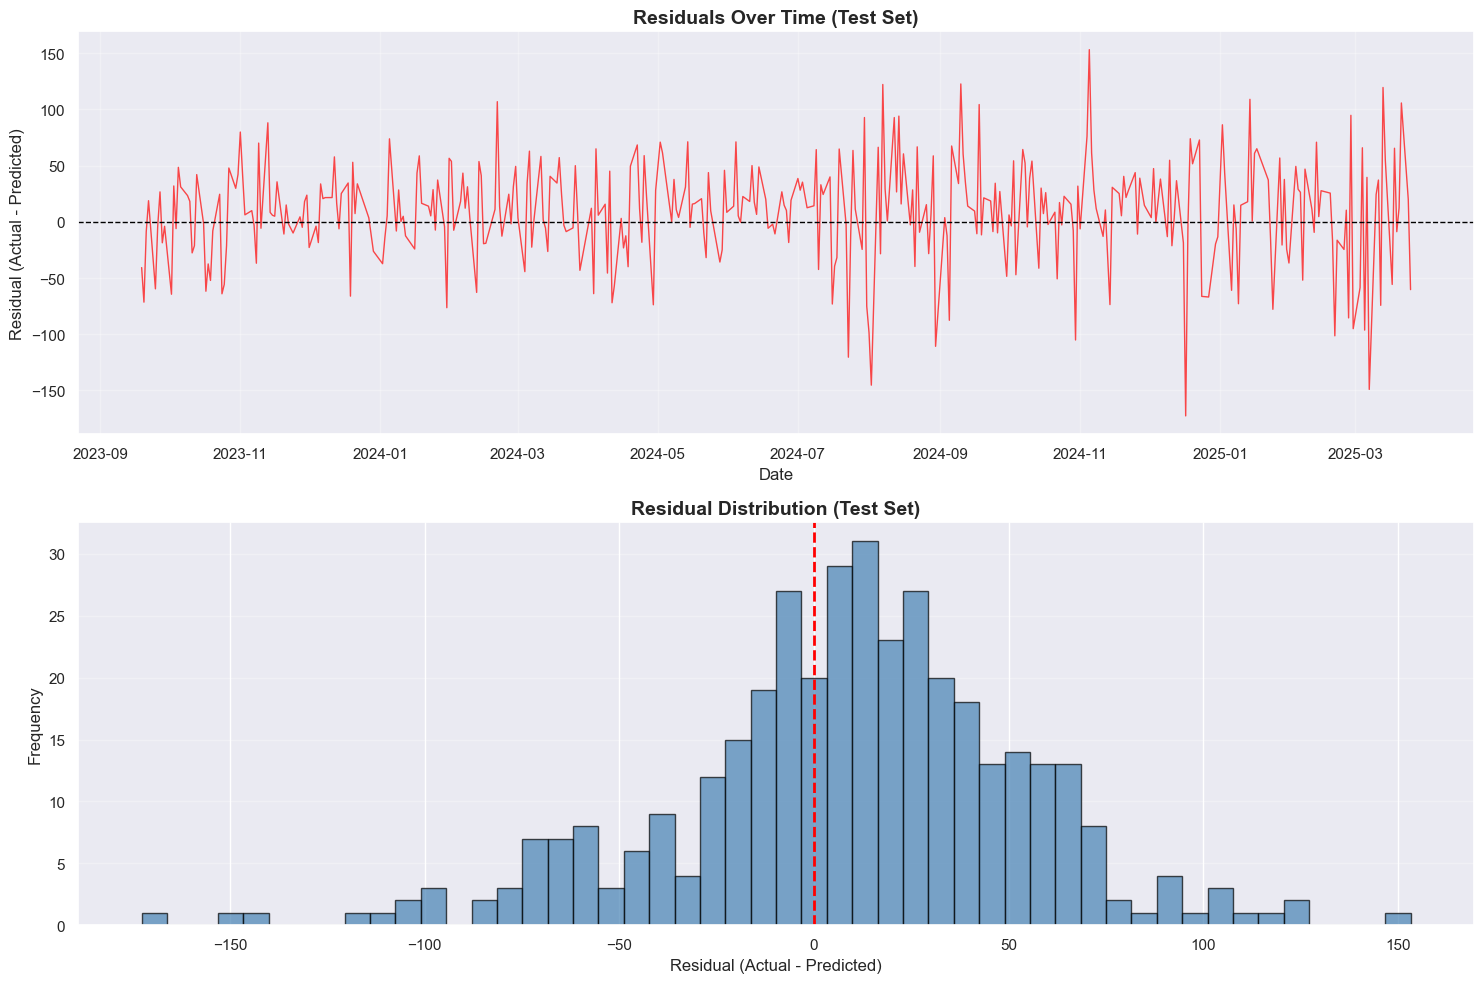

Residual statistics:
  Mean:   8.7847
  Median: 11.3351
  Std:    45.1652


In [30]:
# Use best model (whichever performed better: best_rf or best_xgb)
# For demonstration, we'll use best_rf. Adjust if needed.

residuals = y_test.values - y_pred_best_rf

# --- Plot 1: Residuals over time ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(Date_test, residuals, color="red", alpha=0.7, linewidth=1)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Residuals Over Time (Test Set)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Residual (Actual - Predicted)")
axes[0].grid(True, alpha=0.3)

# --- Plot 2: Histogram of residuals ---
axes[1].hist(residuals, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[1].axvline(0, color="red", linestyle="--", linewidth=2)
axes[1].set_title("Residual Distribution (Test Set)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Residual (Actual - Predicted)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("Residual statistics:")
print(f"  Mean:   {residuals.mean():.4f}")
print(f"  Median: {np.median(residuals):.4f}")
print(f"  Std:    {residuals.std():.4f}")

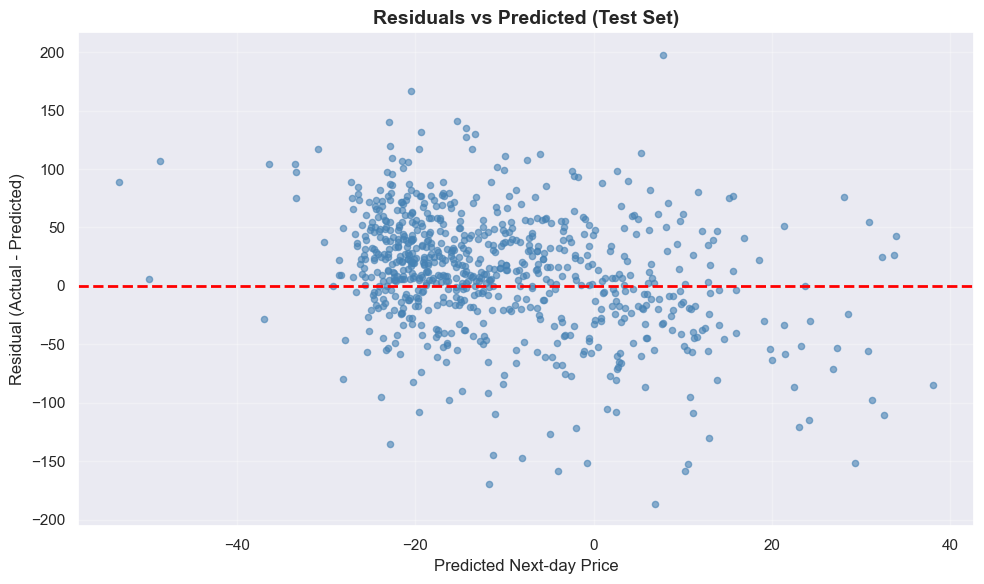

In [57]:
# Scatter: Predicted vs Residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best_rf, residuals, alpha=0.6, s=20, color="steelblue")
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.title("Residuals vs Predicted (Test Set)", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Next-day Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation notes:
# - Residuals centered near zero → no systematic bias
# - Random scatter around 0 → good fit
# - Fanning out (widening spread) → heteroscedasticity (variance increases with prediction level)

## 9. Interpretation — Impact of Previous-Day Data Change
This section explains *how changes in the previous day’s Data* impact next-day stock price movement, as required in the assignment.

In [58]:
# Pick which fitted model to interpret (prefer tuned model if available)
best_model = None
best_model_name = None

if "best_xgb" in globals():
    best_model = best_xgb
    best_model_name = "XGBoost (tuned)"
elif "best_rf" in globals():
    best_model = best_rf
    best_model_name = "RandomForest (tuned)"
else:
    best_model = rf
    best_model_name = "RandomForest (default)"

print("Using model for interpretation:", best_model_name)

# --- Get feature importance in a unified dataframe (Top 15 overall) ---
if hasattr(best_model, "feature_importances_"):
    # RandomForest
    imp_df = pd.DataFrame({
        "feature": X_cols,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)

    imp_type_used = "RF_feature_importances_"

else:
    # XGBoost
    booster = best_model.get_booster()

    try:
        score = booster.get_score(importance_type="gain")
        imp_type_used = "gain"
    except Exception:
        score = booster.get_score(importance_type="weight")
        imp_type_used = "weight"

    def map_feature_name(k, X_cols):
        # "f12" -> X_cols[12], otherwise already a feature name like "Data"
        if isinstance(k, str) and k.startswith("f") and k[1:].isdigit():
            idx = int(k[1:])
            return X_cols[idx] if idx < len(X_cols) else k
        return k

    imp_df = pd.DataFrame({
        "feature": [map_feature_name(k, X_cols) for k in score.keys()],
        "importance": list(score.values())
    }).sort_values("importance", ascending=False)

print("Importance type used:", imp_type_used)
display(imp_df.head(15))

# --- Specifically show importance among "previous day change" related features ---
focus_keywords = ("Data_Change", "Data_Pct_Change", "Data_MA_", "Data_Std_")
focus_df = imp_df[imp_df["feature"].str.contains("|".join(focus_keywords), regex=True)].copy()

print("\nTop features among change/%change/rolling stats:")
display(focus_df.head(15))

# --- Also show the lagged change features explicitly ---
lag_change_df = imp_df[imp_df["feature"].str.contains("Data_Change_Lag_", regex=False)].copy()
print("\nTop lagged change features (Data_Change_Lag_i):")
display(lag_change_df.head(10))

Using model for interpretation: XGBoost (tuned)
Importance type used: RF_feature_importances_


,feature,importance
3,Data_MA_3,0.085328
8,Data_Lag_2,0.082726
5,Data_MA_7,0.074896
9,Data_Lag_3,0.060375
4,Data_MA_5,0.057923
7,Data_Lag_1,0.056594
12,Data_Lag_6,0.055996
20,Data_Change_Lag_7,0.047610
14,Data_Change_Lag_1,0.046864
11,Data_Lag_5,0.045763



Top features among change/%change/rolling stats:


,feature,importance
3,Data_MA_3,0.085328
5,Data_MA_7,0.074896
4,Data_MA_5,0.057923
20,Data_Change_Lag_7,0.047610
14,Data_Change_Lag_1,0.046864
17,Data_Change_Lag_4,0.043037
1,Data_Change,0.042189
19,Data_Change_Lag_6,0.041729
18,Data_Change_Lag_5,0.041307
16,Data_Change_Lag_3,0.037474



Top lagged change features (Data_Change_Lag_i):


,feature,importance
20,Data_Change_Lag_7,0.047610
14,Data_Change_Lag_1,0.046864
17,Data_Change_Lag_4,0.043037
19,Data_Change_Lag_6,0.041729
18,Data_Change_Lag_5,0.041307
16,Data_Change_Lag_3,0.037474
15,Data_Change_Lag_2,0.033978


,Data_Change_Bin,count,mean_data_change,mean_next_day_price_change,median_next_day_price_change
0,"(-0.205, -0.003]",794,-0.010962,1.776448,2.125
1,"(-0.003, -0.001]",722,-0.001399,0.788781,1.500
2,"(-0.001, 0.0]",982,-0.000025,0.722658,1.250
3,"(0.0, 0.003]",591,0.001560,2.870389,1.250
4,"(0.003, 0.142]",696,0.015108,0.330029,1.500


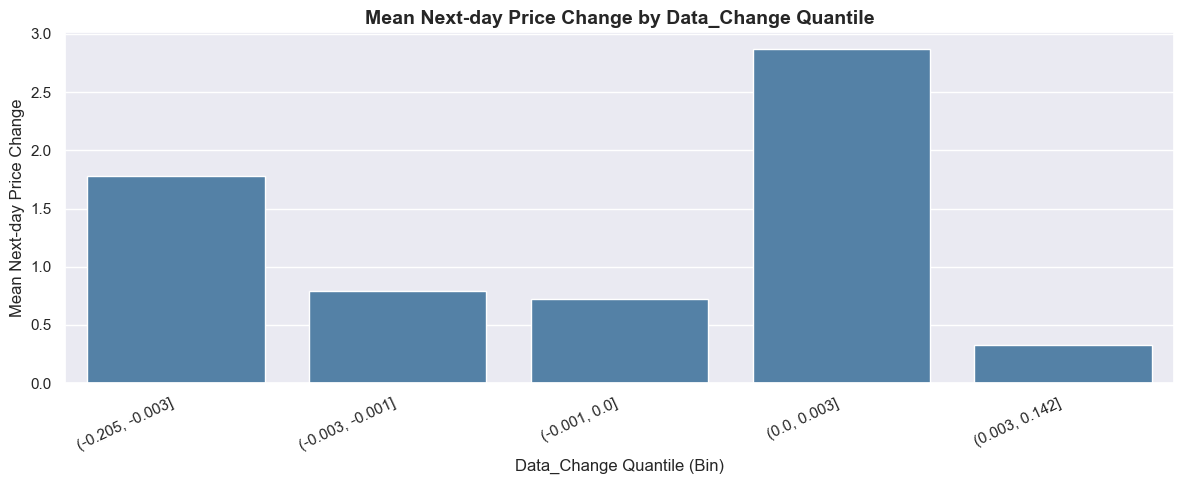


=== Insights (aligning with assignment requirement) ===
- When Data_Change is in the lowest quantile ((-0.205, -0.003]), mean next-day price change is 1.78.
- When Data_Change is in the highest quantile ((0.003, 0.142]), mean next-day price change is 0.33.
- A simple monotonicity signal (sign-sum across bins) is -2 (positive suggests increasing trend, negative suggests decreasing trend).
- Model importance indicates these change/rolling-related features matter most: ['Data_MA_3', 'Data_MA_7', 'Data_MA_5', 'Data_Change_Lag_7', 'Data_Change_Lag_1']
✅ Saved: ../results/data_change_quantile_summary.csv


In [59]:
# We want: "bucket Data_Change into quantiles and show mean next-day price change"
# Next-day price change = (next-day price) - (today's price)
df_int = df_model.copy()
df_int["Price_Change_Next_Day"] = df_int["Target_Price_Next_Day"] - df_int["Price"]

# Quantile buckets (5 buckets); duplicates='drop' handles edge cases
df_int["Data_Change_Bin"] = pd.qcut(df_int["Data_Change"], q=5, duplicates="drop")

summary = (df_int.groupby("Data_Change_Bin")
           .agg(
               count=("Price_Change_Next_Day", "size"),
               mean_data_change=("Data_Change", "mean"),
               mean_next_day_price_change=("Price_Change_Next_Day", "mean"),
               median_next_day_price_change=("Price_Change_Next_Day", "median")
           )
           .reset_index())

# Convert Interval bins to string (avoids display/serialization issues in some environments)
summary["Data_Change_Bin"] = summary["Data_Change_Bin"].astype(str)

display(summary)

# Plot: mean next-day price change by Data_Change quantile
plt.figure(figsize=(12, 5))
sns.barplot(data=summary, x="Data_Change_Bin", y="mean_next_day_price_change", color="steelblue")
plt.title("Mean Next-day Price Change by Data_Change Quantile", fontsize=14, fontweight="bold")
plt.xlabel("Data_Change Quantile (Bin)")
plt.ylabel("Mean Next-day Price Change")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# ---- Write 3–5 insights (data-driven) ----
lowest_bin = summary.iloc[0]
highest_bin = summary.iloc[-1]

print("\n=== Insights (aligning with assignment requirement) ===")
print(f"- When Data_Change is in the lowest quantile ({lowest_bin['Data_Change_Bin']}), "
      f"mean next-day price change is {lowest_bin['mean_next_day_price_change']:.2f}.")
print(f"- When Data_Change is in the highest quantile ({highest_bin['Data_Change_Bin']}), "
      f"mean next-day price change is {highest_bin['mean_next_day_price_change']:.2f}.")

# Show whether the relationship looks monotonic (simple check)
trend = np.sign(summary["mean_next_day_price_change"].diff().dropna()).sum()
print(f"- A simple monotonicity signal (sign-sum across bins) is {trend:.0f} "
      f"(positive suggests increasing trend, negative suggests decreasing trend).")

# Relate to what the model found important
top_focus = focus_df.head(5)["feature"].tolist() if "focus_df" in locals() else []
print(f"- Model importance indicates these change/rolling-related features matter most: {top_focus}")

# Save summary for README / results
summary.to_csv("../results/data_change_quantile_summary.csv", index=False)
print("✅ Saved:", "../results/data_change_quantile_summary.csv")

## 10. Save Artifacts (Model + Predictions + Metrics)
This section saves everything needed for your GitHub submission: the best model, optional pipelines, predictions, and metrics summaries.

In [60]:
import os
import json

# Output folders (notebook is in: project/notebooks/)
MODELS_DIR = "../models"
RESULTS_DIR = "../results"

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Choose the "best" model object to save
# Priority: tuned XGB > tuned RF > default RF
model_to_save = None
model_name = None

if "best_xgb" in globals():
    model_to_save = best_xgb
    model_name = "xgb_best"
elif "best_rf" in globals():
    model_to_save = best_rf
    model_name = "rf_best"
else:
    model_to_save = rf
    model_name = "rf_default"

print("Saving model:", model_name)

# Save the model
model_path = os.path.join(MODELS_DIR, f"{model_name}.joblib")
joblib.dump(model_to_save, model_path)
print("✅ Model saved to:", model_path)

# Save scaler/pipeline IF used (example: ridge_pipe / linreg_pipe)
# (These are optional. Save only if they exist in your notebook.)
if "ridge_pipe" in globals():
    ridge_path = os.path.join(MODELS_DIR, "ridge_pipe.joblib")
    joblib.dump(ridge_pipe, ridge_path)
    print("✅ Saved pipeline:", ridge_path)

if "linreg_pipe" in globals():
    linreg_path = os.path.join(MODELS_DIR, "linreg_pipe.joblib")
    joblib.dump(linreg_pipe, linreg_path)
    print("✅ Saved pipeline:", linreg_path)


Saving model: xgb_best
✅ Model saved to: ../models\xgb_best.joblib
✅ Saved pipeline: ../models\ridge_pipe.joblib
✅ Saved pipeline: ../models\linreg_pipe.joblib


In [61]:
# Decide which predictions/metrics to store (use the same chosen model)
if model_name == "xgb_best":
    y_pred_best = y_pred_best_xgb
    metrics_best = metrics_best_xgb
elif model_name == "rf_best":
    y_pred_best = y_pred_best_rf
    metrics_best = metrics_best_rf
else:
    y_pred_best = y_pred_rf
    metrics_best = metrics_rf

# Save test predictions CSV
pred_path = os.path.join(RESULTS_DIR, f"{model_name}_test_predictions.csv")

pred_df = pd.DataFrame({
    "Date": Date_test.astype(str).values,
    "y_true": y_test.values,
    "y_pred": y_pred_best
})
pred_df.to_csv(pred_path, index=False)
print("✅ Test predictions saved to:", pred_path)
display(pred_df.head(10))

# Save metrics for README (JSON + TXT)
metrics_payload = {
    "selected_model": model_name,
    "metrics": metrics_best,
    "baseline_persistence": metrics_persistence if "metrics_persistence" in globals() else None,
    "baseline_linear_regression": metrics_linreg if "metrics_linreg" in globals() else None,
    "tuning_results": tuning_results if "tuning_results" in globals() else None
}

metrics_json_path = os.path.join(RESULTS_DIR, "metrics.json")
with open(metrics_json_path, "w") as f:
    json.dump(metrics_payload, f, indent=2)

metrics_txt_path = os.path.join(RESULTS_DIR, "metrics.txt")
with open(metrics_txt_path, "w") as f:
    f.write(f"Selected model: {model_name}\n")
    f.write("Selected model metrics:\n")
    for k, v in metrics_best.items():
        f.write(f"  {k}: {v}\n")

print("✅ Metrics saved to:")
print(" -", metrics_json_path)
print(" -", metrics_txt_path)

# Save feature list (important for reproducibility)
features_path = os.path.join(RESULTS_DIR, "features_used.json")
with open(features_path, "w") as f:
    json.dump({"X_cols": X_cols, "y_col": y_col}, f, indent=2)

print("✅ Feature list saved to:", features_path)

✅ Test predictions saved to: ../results\xgb_best_test_predictions.csv


,Date,y_true,y_pred
0,2022-03-10,-55.75,2.626598
1,2022-03-11,-29.50,-16.073154
2,2022-03-14,90.00,0.379687
3,2022-03-15,96.00,3.240110
4,2022-03-16,52.50,-0.250186
5,2022-03-17,51.50,-5.812784
6,2022-03-18,-1.25,2.867487
7,2022-03-21,52.75,11.848441
8,2022-03-22,-57.50,0.643700
9,2022-03-23,65.00,0.653528


✅ Metrics saved to:
 - ../results\metrics.json
 - ../results\metrics.txt
✅ Feature list saved to: ../results\features_used.json


## 11. Final Checks (Reproducibility)
One cell to confirm the final model, metrics, and saved artifacts are present before pushing to GitHub.

In [62]:
import os
import json

# These should match what you used in the "Save Artifacts" section
MODELS_DIR = "../models"
RESULTS_DIR = "../results"

def exists(p):
    return os.path.exists(p)

print("=== FINAL REPRODUCIBILITY CHECK ===")

# 1) Determine selected model (same logic used earlier)
if "model_name" in globals() and model_name is not None:
    selected_model = model_name
else:
    if "best_xgb" in globals():
        selected_model = "xgb_best"
    elif "best_rf" in globals():
        selected_model = "rf_best"
    else:
        selected_model = "rf_default"

print("\nSelected model:", selected_model)

# 2) Determine final metrics (same selection logic)
if selected_model == "xgb_best" and "metrics_best_xgb" in globals():
    final_metrics = metrics_best_xgb
elif selected_model == "rf_best" and "metrics_best_rf" in globals():
    final_metrics = metrics_best_rf
elif "metrics_rf" in globals():
    final_metrics = metrics_rf
else:
    final_metrics = None

print("\nFinal metrics:")
print(final_metrics)

# 3) Confirm output files exist
expected_files = [
    os.path.join(MODELS_DIR, f"{selected_model}.joblib"),
    os.path.join(RESULTS_DIR, f"{selected_model}_test_predictions.csv"),
    os.path.join(RESULTS_DIR, "metrics.json"),
    os.path.join(RESULTS_DIR, "metrics.txt"),
    os.path.join(RESULTS_DIR, "features_used.json"),
]

print("\nArtifact existence check:")
missing_files = []
for p in expected_files:
    ok = exists(p)
    print(f" - {p}: {'✅' if ok else '❌'}")
    if not ok:
        missing_files.append(p)

# 4) Print model + features used
print("\nFeatures used (X_cols):")
print(X_cols)

print("\nTarget (y_col):", y_col)

# 5) If features file exists, show it as confirmation
features_path = os.path.join(RESULTS_DIR, "features_used.json")
if exists(features_path):
    with open(features_path, "r") as f:
        saved_features = json.load(f)
    print("\nLoaded features_used.json successfully.")
    print("Saved y_col:", saved_features.get("y_col"))
    print("Saved X_cols length:", len(saved_features.get("X_cols", [])))

# 6) Final verdict
if len(missing_files) == 0 and final_metrics is not None:
    print("\n✅ Ready to push to GitHub.")
else:
    print("\n❌ Not ready yet.")
    if final_metrics is None:
        print(" - Final metrics not found. Run the model training + evaluation cells first.")
    if missing_files:
        print(" - Missing artifacts:")
        for p in missing_files:
            print("   ", p)

=== FINAL REPRODUCIBILITY CHECK ===

Selected model: xgb_best

Final metrics:
{'MSE': 2409.531130375068, 'RMSE': 49.0869751601692, 'MAE': 37.23004144585668, 'R2': -0.035702377736571256, 'MAPE(%)': inf}

Artifact existence check:
 - ../models\xgb_best.joblib: ✅
 - ../results\xgb_best_test_predictions.csv: ✅
 - ../results\metrics.json: ✅
 - ../results\metrics.txt: ✅
 - ../results\features_used.json: ✅

Features used (X_cols):
['Data', 'Data_Change', 'Data_Pct_Change', 'Data_MA_3', 'Data_MA_5', 'Data_MA_7', 'Data_Std_7', 'Data_Lag_1', 'Data_Lag_2', 'Data_Lag_3', 'Data_Lag_4', 'Data_Lag_5', 'Data_Lag_6', 'Data_Lag_7', 'Data_Change_Lag_1', 'Data_Change_Lag_2', 'Data_Change_Lag_3', 'Data_Change_Lag_4', 'Data_Change_Lag_5', 'Data_Change_Lag_6', 'Data_Change_Lag_7']

Target (y_col): TargetPriceChange

Loaded features_used.json successfully.
Saved y_col: TargetPriceChange
Saved X_cols length: 21

✅ Ready to push to GitHub.
